In [18]:
import joblib
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import time
from tkinter import *
from tkinter import filedialog
from tqdm import tqdm
import itertools
import math

In [50]:
def adp_filt(currdf: object, pose):
    lIndex = []
    xIndex = []
    yIndex = []
    currdf = np.array(currdf[1:])
    for header in pose:
        if currdf[0][header + 1] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header + 1] == "x":
            xIndex.append(header)
        elif currdf[0][header + 1] == "y":
            yIndex.append(header)
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[1:, np.array(xIndex)]
    datay = curr_df1[1:, np.array(yIndex)]
    data_lh = curr_df1[1:, np.array(lIndex)]
    currdf_filt = np.zeros((datax.shape[0], (datax.shape[1]) * 2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = b[rise_a[0][0]]
        else:
            llh = b[rise_a[0][1]]
        # llh=0
        data_lh_float = data_lh[:, x].astype(np.float)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        currdf_filt[0, (2 * x):(2 * x + 2)] = np.hstack([datax[0, x], datay[0, x]])
        for i in range(1, data_lh.shape[0]):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt)
    currdf_filt = currdf_filt.astype(np.float)
    return currdf_filt, perc_rect

def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg

In [51]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles = filedialog.askopenfilename(multiple=True, title='load deeplabcut csv')

%gui tk

In [52]:
df = pd.read_csv(infiles[0], low_memory=False)

In [53]:
df

,scorer,DLC_resnet50_bottomup_clearSep21shuffle1_1030000,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.1,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.2,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.3,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.4,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.5,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.6,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.7,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.8,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.9,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.10,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.11,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.12,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.13,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.14,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.15,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.16,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.17
0,bodyparts,snout,snout,snout,right-forepaw,right-forepaw,right-forepaw,left-forepaw,left-forepaw,left-forepaw,right-hindpaw,right-hindpaw,right-hindpaw,left-hindpaw,left-hindpaw,left-hindpaw,tail-base,tail-base,tail-base
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,0,770.8351440429688,567.4705810546875,0.9890758991241455,757.4652099609375,567.7769775390625,0.9988705515861511,748.8650512695312,589.75634765625,0.999021053314209,708.3623046875,561.6245727539062,0.9997289776802063,677.396240234375,600.2677001953125,0.9998993873596191,664.3548583984375,574.5863037109375,0.9996558427810669
3,1,768.6314086914062,564.6966552734375,0.9897860288619995,756.7302856445312,567.3088989257812,0.9984824061393738,749.5425415039062,590.5848999023438,0.9993357062339783,707.1015014648438,561.972900390625,0.9996579885482788,677.739501953125,600.2362060546875,0.9998801946640015,662.8864135742188,573.4024047851562,0.9998563528060913
4,2,765.8948364257812,562.3164672851562,0.9981891512870789,747.7654418945312,562.8372192382812,0.9993269443511963,750.2341918945312,590.4234008789062,0.9991907477378845,706.387939453125,561.4625244140625,0.9997993111610413,678.2116088867188,600.3167114257812,0.9998658895492554,663.49853515625,574.06005859375,0.9998573064804077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161584,161582,715.0020751953125,179.82601928710938,0.9983914494514465,730.019287109375,197.030029296875,0.9769902229309082,731.938232421875,190.35972595214844,0.8282947540283203,751.6287841796875,211.7681884765625,0.9994458556175232,728.0454711914062,186.34701538085938,0.9560379981994629,767.62744140625,176.62684631347656,0.9996780157089233
161585,161583,713.2131958007812,181.43710327148438,0.9991058707237244,730.9525756835938,197.39146423339844,0.9629812836647034,731.984375,191.83067321777344,0.9199346303939819,751.5671997070312,211.9090118408203,0.999230146408081,725.4998168945312,186.25791931152344,0.9685111045837402,762.5570678710938,175.86172485351562,0.9994325041770935
161586,161584,714.2919921875,181.9589080810547,0.999313473701477,731.3096313476562,196.9551239013672,0.9775495529174805,732.817138671875,191.1296844482422,0.9191429615020752,751.6978759765625,211.64785766601562,0.9988784193992615,724.2835693359375,186.49163818359375,0.9296874403953552,761.2387084960938,174.36753845214844,0.9994789958000183
161587,161585,713.1619262695312,182.71971130371094,0.9991796612739563,731.5374755859375,197.9582977294922,0.9649544954299927,731.781494140625,192.1973114013672,0.9067642092704773,751.6336059570312,211.60379028320312,0.9992129802703857,725.2329711914062,187.26451110839844,0.9660616517066956,759.744384765625,174.40631103515625,0.9998055100440979


In [54]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles_clf = filedialog.askopenfilename(multiple=False, title='load classifier file .sav')

%gui tk

In [55]:
infiles_clf

'D:/DeepLabStream/Sep-07-2022_randomforest.sav'

In [56]:
with open(infiles_clf, 'rb') as fr:
    random_forest_sav = joblib.load(fr)

C:\Users\jimi\anaconda3\envs\closed-loop\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\jimi\anaconda3\envs\closed-loop\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [57]:
clf = random_forest_sav[3]
clf

RandomForestClassifier(max_features='auto', random_state=42)

In [58]:
csv_array_filtered, perc_filtered = adp_filt(df, np.arange(18))

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\jimi\AppData\Local\Temp\ipykernel_21944\3076676940.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a, b = np.histogram(data_lh[1:, x].astype(np.float))
C:\Users\jimi\AppData\Local\Temp\ipykernel_21944\3076676940.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

In [59]:
csv_array_filtered.shape

(161587, 12)

In [60]:
# csv_array.shape
processed_input_data = [csv_array_filtered.copy()]

In [61]:
framerate = 30
window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
f = []
for n in range(len(processed_input_data)):
    data_n_len = len(processed_input_data[n])
    dxy_list = []
    disp_list = []
    for r in range(data_n_len):
        if r < data_n_len - 1:
            disp = []
            for c in range(0, processed_input_data[n].shape[1], 2):
                disp.append(
                    np.linalg.norm(processed_input_data[n][r + 1, c:c + 2] -
                                   processed_input_data[n][r, c:c + 2]))
            disp_list.append(disp)
        dxy = []
        for i, j in itertools.combinations(range(0, processed_input_data[n].shape[1], 2), 2):
            dxy.append(processed_input_data[n][r, i:i + 2] -
                       processed_input_data[n][r, j:j + 2])
        dxy_list.append(dxy)
    disp_r = np.array(disp_list)
    dxy_r = np.array(dxy_list)
    disp_boxcar = []
    dxy_eu = np.zeros([data_n_len, dxy_r.shape[1]])
    ang = np.zeros([data_n_len - 1, dxy_r.shape[1]])
    dxy_boxcar = []
    ang_boxcar = []
    for l in range(disp_r.shape[1]):
        disp_boxcar.append(boxcar_center(disp_r[:, l], window))
        # disp_boxcar.append(disp_r[:, l])
    for k in range(dxy_r.shape[1]):
        for kk in range(data_n_len):
            dxy_eu[kk, k] = np.linalg.norm(dxy_r[kk, k, :])
            if kk < data_n_len - 1:
                b_3d = np.hstack([dxy_r[kk + 1, k, :], 0])
                a_3d = np.hstack([dxy_r[kk, k, :], 0])
                c = np.cross(b_3d, a_3d)
                ang[kk, k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                    math.atan2(np.linalg.norm(c),
                                               np.dot(dxy_r[kk, k, :], dxy_r[kk + 1, k, :])))
        dxy_boxcar.append(boxcar_center(dxy_eu[:, k], window))
        ang_boxcar.append(boxcar_center(ang[:, k], window))
        # dxy_boxcar.append(dxy_eu[:, k])
        # ang_boxcar.append(ang[:, k])
    disp_feat = np.array(disp_boxcar)
    dxy_feat = np.array(dxy_boxcar)
    ang_feat = np.array(ang_boxcar)
    f.append(np.vstack((dxy_feat[:, 1:], ang_feat, disp_feat)))

for m in range(0, len(f)):
    f_integrated = np.zeros(len(processed_input_data[m]))
    for k in range(round(framerate / 10), len(f[m][0]), round(framerate / 10)):
        if k > round(framerate / 10):
            f_integrated = np.concatenate(
                (f_integrated.reshape(f_integrated.shape[0], f_integrated.shape[1]),
                 np.hstack((np.mean((f[m][0:dxy_feat.shape[0],
                                     range(k - round(framerate / 10), k)]), axis=1),
                            np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                                    range(k - round(framerate / 10), k)]), axis=1)
                            )).reshape(len(f[0]), 1)), axis=1
            )
        else:
            f_integrated = np.hstack(
                (np.mean((f[m][0:dxy_feat.shape[0], range(k - round(framerate / 10), k)]), axis=1),
                 np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                         range(k - round(framerate / 10), k)]), axis=1))).reshape(len(f[0]), 1)
    if m > 0:
        features = np.concatenate((features, f_integrated), axis=1)
    else:
        features = f_integrated

C:\Users\jimi\AppData\Local\Temp\ipykernel_21944\1596035890.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)


In [62]:
f_integrated.T.shape

(53861, 36)

In [63]:
X = features.T.copy()
predictions = clf.predict(X)

Text(0.5, 0, 'time (s)')

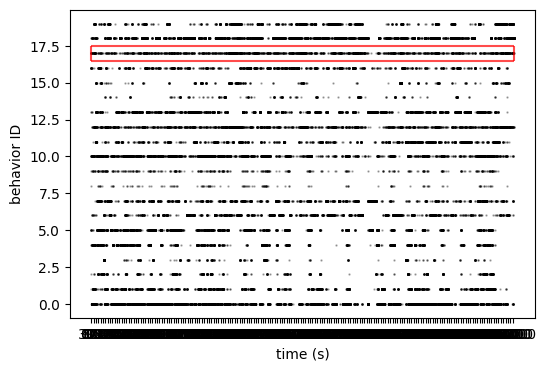

In [64]:
class_of_interest=17
jitter=0.5
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hlines(class_of_interest-jitter, 0, len(predictions), 'r', alpha=0.7)
ax.hlines(class_of_interest+jitter, 0, len(predictions), 'r', alpha=0.7)
ax.vlines(0-jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.vlines(len(predictions)+jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.scatter(np.arange(len(predictions)), predictions, s=0.5, color='k', alpha=0.3)
ax.set_xticks(np.arange(0, len(predictions), 300))
ax.set_xticklabels(np.arange(0, len(predictions)/10, 30))
ax.set_ylabel('behavior ID')
ax.set_xlabel('time (s)')
# fig.savefig('./test.png', dpi=600)

In [65]:
fileoutname = str.join('', (infiles[0].rpartition('DLC')[0], '_posthoc-predictions.npy'))
np.save(fileoutname, predictions)

## put the below code in another notebook 
#### loop through all .npy files once analyzed

In [63]:
all_predictions = []
for _ in range(6):
    # join duplicates of the same array
    predictions = np.load(fileoutname)
    all_predictions.append(predictions)
# all_predictions
all_predictions_arr = np.hstack(all_predictions)

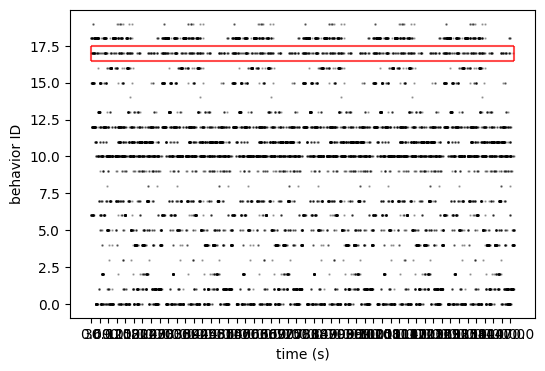

In [79]:
class_of_interest=17
jitter=0.5
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hlines(class_of_interest-jitter, 0, len(all_predictions_arr), 'r', alpha=0.7)
ax.hlines(class_of_interest+jitter, 0, len(all_predictions_arr), 'r', alpha=0.7)
ax.vlines(0-jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.vlines(len(all_predictions_arr)+jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.scatter(np.arange(len(all_predictions_arr)), all_predictions_arr, s=0.5, color='k', alpha=0.3)
ax.set_xticks(np.arange(0, len(all_predictions_arr), 300))
ax.set_xticklabels(np.arange(0, len(all_predictions_arr)/10, 30))
ax.set_ylabel('behavior ID')
ax.set_xlabel('time (s)')
fig.savefig('./test.png', dpi=600)

In [67]:
all_predictions_arr.shape

(14826,)

In [70]:
bin_start = np.arange(0, np.max(len(all_predictions_arr)), 600)
bin_end = np.arange(600, np.max(len(all_predictions_arr))+600, 600)
print(bin_start, bin_end)
binned_predictions = []
for b in range(len(bin_start)):
    binned_predictions.append(all_predictions_arr[bin_start[b]:bin_end[b]])


[    0   600  1200  1800  2400  3000  3600  4200  4800  5400  6000  6600
  7200  7800  8400  9000  9600 10200 10800 11400 12000 12600 13200 13800
 14400] [  600  1200  1800  2400  3000  3600  4200  4800  5400  6000  6600  7200
  7800  8400  9000  9600 10200 10800 11400 12000 12600 13200 13800 14400
 15000]


<BarContainer object of 25 artists>

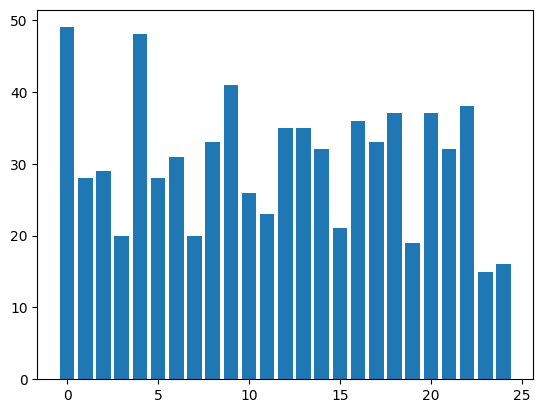

In [80]:
class_interest_binned = [len(np.where(binned_predictions[b] == class_of_interest)[0]) for b in range(len(binned_predictions))]

plt.bar(np.arange(len(class_interest_binned)), class_interest_binned)

In [42]:
np.arange(0, len(predictions), 300), np.arange(0, len(predictions)/10, 30)

(array([   0,  300,  600,  900, 1200, 1500, 1800, 2100, 2400]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240.]))